In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import time

from datetime import datetime
from datetime import time as dtime

# Xử lý price

### Xác định các khoảng thời gian

In [2]:
price_history_df = pd.read_csv(r'C:\STUDY\code\tiki_data\price_history_cleaned.csv')
sales_history_df = pd.read_csv(r'C:\STUDY\code\tiki_data\sales_history_cleaned.csv')
product_details_df = pd.read_csv(r'C:\STUDY\code\tiki_data\product_details_cleaned.csv')
rating_history_df = pd.read_csv(r'C:\STUDY\code\tiki_data\rating_history_cleaned.csv')

In [3]:
price_history_df['crawl_timestamp'] = pd.to_datetime(price_history_df['crawl_timestamp'])

In [15]:
def convert_timestamp_to_date(df, timestamp_col='crawl_timestamp', date_col='date'):
    """
    Chuyển đổi cột crawl_timestamp thành cột date (chỉ lấy phần ngày)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame chứa cột crawl_timestamp
    timestamp_col : str, default='crawl_timestamp'
        Tên cột timestamp cần chuyển đổi
    date_col : str, default='date'
        Tên cột date mới sẽ được tạo
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame với cột date mới được thêm vào
    
    Example:
    --------
    >>> df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])
    >>> df = convert_timestamp_to_date(df)
    >>> print(df[['crawl_timestamp', 'date']].head())
    """
    df = df.copy()
    # Đảm bảo cột timestamp đã là datetime
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Chuyển đổi thành date (chỉ lấy phần ngày)
    df[date_col] = df[timestamp_col].dt.date
    
    return df

# Áp dụng hàm cho price_history_df
price_history_df = convert_timestamp_to_date(price_history_df, 'crawl_timestamp', 'date')

# Kiểm tra kết quả
print("✅ Đã tạo cột 'date' từ 'crawl_timestamp'")
print(f"\n📊 Ví dụ 5 dòng đầu:")
print(price_history_df[['crawl_timestamp', 'date']].head())
print(f"\n📅 Kiểu dữ liệu:")
print(f"  - crawl_timestamp: {price_history_df['crawl_timestamp'].dtype}")
print(f"  - date: {price_history_df['date'].dtype}")


✅ Đã tạo cột 'date' từ 'crawl_timestamp'

📊 Ví dụ 5 dòng đầu:
             crawl_timestamp        date
0 2025-11-02 10:45:20.297907  2025-11-02
1 2025-11-02 10:45:20.297907  2025-11-02
2 2025-11-02 10:45:20.297907  2025-11-02
3 2025-11-02 10:45:20.297907  2025-11-02
4 2025-11-02 10:45:20.297907  2025-11-02

📅 Kiểu dữ liệu:
  - crawl_timestamp: datetime64[ns]
  - date: object


In [4]:
from datetime import time as dtime

# Định nghĩa các khoảng thời gian crawl
sections = [
    ('20h30-1h', dtime(20, 30), dtime(1, 0)),      # 20:30 hôm nay đến 01:00 hôm sau
    ('10h-13h', dtime(10, 0), dtime(13, 0)),
    ('15h30-17h30', dtime(15, 30), dtime(17, 30)),
]

# Vectorized cột giờ và mask ngày
crawl_times = price_history_df['crawl_timestamp'].dt.time
crawl_dates = price_history_df['crawl_timestamp'].dt.date

cond_20h30_1h = (crawl_times >= dtime(20, 30)) | (crawl_times <= dtime(1, 0))

cond_10h_13h = (crawl_times >= dtime(10, 0)) & (crawl_times <= dtime(13, 0))
cond_15h30_17h30 = (crawl_times >= dtime(15, 30)) & (crawl_times <= dtime(17, 30))

# Áp nhãn section bằng hàm vectorized:
section_labels = np.full(len(price_history_df), None, dtype=object)
section_labels[cond_20h30_1h] = '20h30-1h'
section_labels[cond_10h_13h] = '10h-13h'
section_labels[cond_15h30_17h30] = '15h30-17h30'

# Gán lại
price_history_df['crawl_section'] = section_labels

prod_id_col = "product_id"

# Thống kê nhanh
print("Phân bố records theo section:")
print(price_history_df['crawl_section'].value_counts(dropna=False))
print(f"\nTổng records có section hợp lệ: {price_history_df['crawl_section'].notnull().sum():,}")


Phân bố records theo section:
crawl_section
20h30-1h       119893
10h-13h         85871
15h30-17h30     67500
None            37500
Name: count, dtype: int64

Tổng records có section hợp lệ: 273,264


In [5]:
### PHIÊN BẢN ĐƠN GIẢN - GIỮ TẤT CẢ RECORDS TRONG 3 KHUNG GIỜ ###

# Đơn giản chỉ lọc các records có crawl_section hợp lệ (không None)
full_section_logs_df = price_history_df[price_history_df['crawl_section'].notnull()].copy()

print(f"✅ Tổng số records sau khi lọc: {len(full_section_logs_df):,}")
print(f"✅ Số unique products: {full_section_logs_df[prod_id_col].nunique():,}")
print(f"\n📊 Phân bố theo section:")
print(full_section_logs_df['crawl_section'].value_counts().sort_index())



✅ Tổng số records sau khi lọc: 273,264
✅ Số unique products: 4,292

📊 Phân bố theo section:
crawl_section
10h-13h         85871
15h30-17h30     67500
20h30-1h       119893
Name: count, dtype: int64


Số ngày có đủ cả 3 khung giờ: 15 / 30


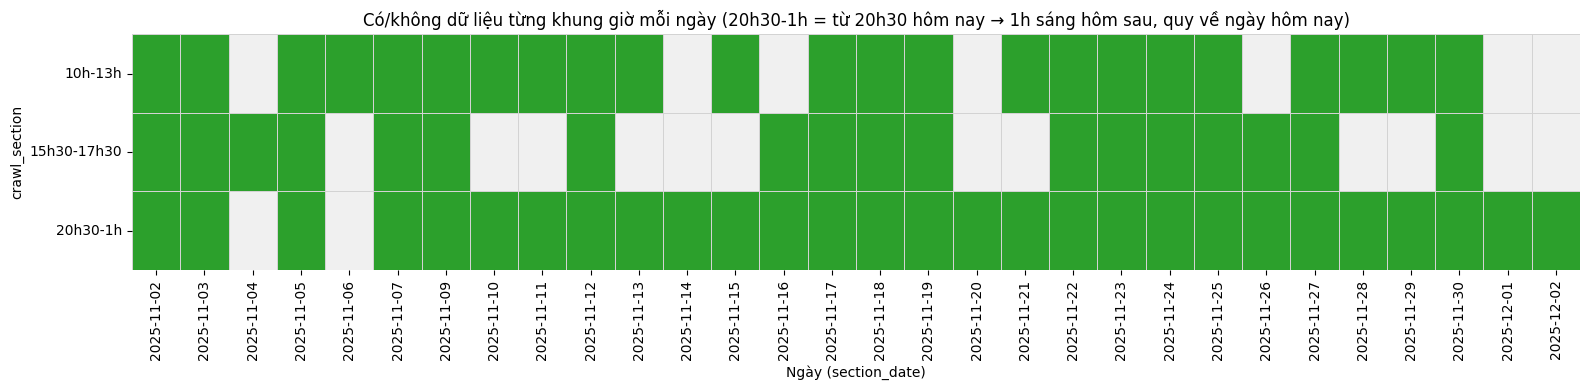

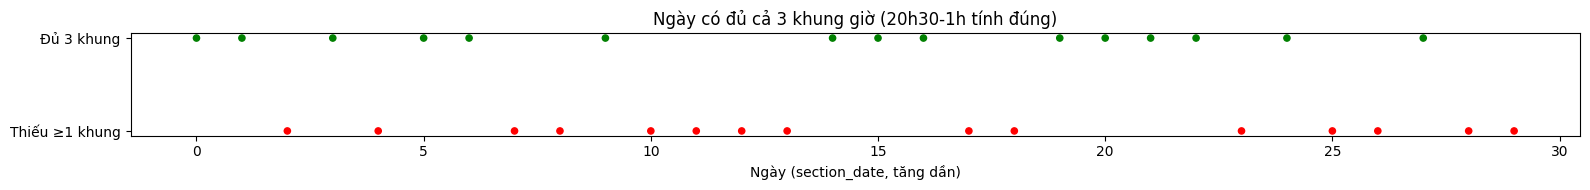

In [6]:
full_section_logs_df = full_section_logs_df.copy()
df = full_section_logs_df

# Đơn giản vì cách phân chia section ban đầu là đúng (20h30-1h)
# -> section_date = ngày của timestamp

df['section_date'] = df['crawl_timestamp'].dt.date

sections_order = ['10h-13h', '15h30-17h30', '20h30-1h']

# Đếm số bản ghi theo (section_date, crawl_section)
daily_section_counts = (
    df
    .groupby(['section_date', 'crawl_section'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=sections_order, fill_value=0)
    .sort_index()
)

daily_section_presence = daily_section_counts > 0
daily_has_all = daily_section_presence.all(axis=1)

print("Số ngày có đủ cả 3 khung giờ:", int(daily_has_all.sum()), "/", len(daily_has_all))

# Heatmap trực quan: dòng là section, cột là ngày
plt.figure(figsize=(16, 4))
sns.heatmap(
    daily_section_presence.T.astype(int),
    cmap=sns.color_palette(['#f0f0f0', '#2ca02c']),
    cbar=False,
    linewidths=0.5,
    linecolor='lightgray'
)
plt.yticks(rotation=0)
plt.xlabel("Ngày (section_date)")
plt.title("Có/không dữ liệu từng khung giờ mỗi ngày (20h30-1h = từ 20h30 hôm nay → 1h sáng hôm sau, quy về ngày hôm nay)")
plt.tight_layout()
plt.show()

# Tóm tắt đủ/thiếu ngày có đủ cả 3 block
plt.figure(figsize=(16, 2))
colors = daily_has_all.map({True: 'green', False: 'red'})
plt.scatter(range(len(daily_has_all)), daily_has_all.astype(int), c=colors, s=20)
plt.yticks([0, 1], ['Thiếu ≥1 khung', 'Đủ 3 khung'])
plt.xlabel("Ngày (section_date, tăng dần)")
plt.title("Ngày có đủ cả 3 khung giờ (20h30-1h tính đúng)")
plt.tight_layout()
plt.show()

### Chuyển đổi cột date

In [16]:
def convert_timestamp_to_date(df, timestamp_col='crawl_timestamp', date_col='date'):
    """
    Chuyển đổi cột crawl_timestamp thành cột date (chỉ lấy phần ngày)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame chứa cột crawl_timestamp
    timestamp_col : str, default='crawl_timestamp'
        Tên cột timestamp cần chuyển đổi
    date_col : str, default='date'
        Tên cột date mới sẽ được tạo
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame với cột date mới được thêm vào
    
    Example:
    --------
    >>> df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])
    >>> df = convert_timestamp_to_date(df)
    >>> print(df[['crawl_timestamp', 'date']].head())
    """
    df = df.copy()
    # Đảm bảo cột timestamp đã là datetime
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Chuyển đổi thành date (chỉ lấy phần ngày)
    df[date_col] = df[timestamp_col].dt.date
    
    return df


✅ Đã tạo cột 'date' từ 'crawl_timestamp'

📊 Ví dụ 5 dòng đầu:
             crawl_timestamp        date
0 2025-11-02 10:45:20.297907  2025-11-02
1 2025-11-02 10:45:20.297907  2025-11-02
2 2025-11-02 10:45:20.297907  2025-11-02
3 2025-11-02 10:45:20.297907  2025-11-02
4 2025-11-02 10:45:20.297907  2025-11-02

📅 Kiểu dữ liệu:
  - crawl_timestamp: datetime64[ns]
  - date: object


In [17]:
full_section_logs_df = convert_timestamp_to_date(full_section_logs_df, 'crawl_timestamp', 'date')

### Kiểm tra duplicate

In [31]:
from datetime import date as date_type

full_section_logs_df[
    (full_section_logs_df['product_id'] == 54665) &
    (full_section_logs_df['date'] == date_type(2025, 11, 28))
].head(5)

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date
262014,262803,54665,Chuột không dây Logitech M185 - Hãng chính hãng,Thiết bị KTS phụ kiện số,225000.0,261000.0,36000.0,14,2025-11-28 11:17:10.037507,10h-13h,2025-11-28,2025-11-28
265764,266555,54665,Chuột không dây Logitech M185 - Hãng chính hãng,Thiết bị KTS phụ kiện số,225000.0,261000.0,36000.0,14,2025-11-28 21:58:01.191403,20h30-1h,2025-11-28,2025-11-28
265765,270305,54665,Chuột không dây Logitech M185 - Hãng chính hãng,Thiết bị KTS phụ kiện số,225000.0,261000.0,36000.0,14,2025-11-28 21:58:01.191403,20h30-1h,2025-11-28,2025-11-28


In [34]:
from datetime import date as date_type

full_section_logs_df[
    (full_section_logs_df['product_id'] == 299431) &
    (full_section_logs_df['date'] == date_type(2025, 11, 28))
].head(5)

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date
262015,262964,299431,Chuột Không Dây Logitech M221 - Hàng Chính Hãng,Thiết bị KTS phụ kiện số,229000.0,229000.0,0.0,0,2025-11-28 11:17:10.037507,10h-13h,2025-11-28,2025-11-28
265766,266714,299431,Chuột Không Dây Logitech M221 - Hàng Chính Hãng,Thiết bị KTS phụ kiện số,229000.0,229000.0,0.0,0,2025-11-28 21:58:01.191403,20h30-1h,2025-11-28,2025-11-28
265767,270464,299431,Chuột Không Dây Logitech M221 - Hàng Chính Hãng,Thiết bị KTS phụ kiện số,229000.0,229000.0,0.0,0,2025-11-28 21:58:01.191403,20h30-1h,2025-11-28,2025-11-28


T có thể thấy ở 2 sản phẩm trên đều bị duplicate ở crawl_section 20h30-1h -> **Đây là sơ xuất của tác giả bộ dữ liệu khi tiến hành `update` database.

In [35]:
full_section_logs_df.shape

(273264, 12)

In [39]:
def remove_duplicates(df):
    """
    Xóa các dòng duplicate (do update database 2 lần)
    Loại trừ cột 'id' khi kiểm tra duplicate vì mỗi lần update có id khác nhau
    Giữ lại dòng đầu tiên, xóa các dòng duplicate sau đó
    """
    rows_before = len(df)
    
    # Lấy tất cả các cột trừ cột 'id' để kiểm tra duplicate
    cols_to_check = [col for col in df.columns if col != 'id']
    
    # Xóa duplicate dựa trên các cột (trừ id)
    df_cleaned = df.drop_duplicates(subset=cols_to_check, keep='first')
    rows_removed = rows_before - len(df_cleaned)
    
    print(f"✅ Đã xóa {rows_removed:,} dòng duplicate")
    print(f"📊 Số dòng trước: {rows_before:,}")
    print(f"📊 Số dòng sau: {len(df_cleaned):,}")
    
    return df_cleaned

# Áp dụng hàm để xóa duplicate
price_history_cleaned = remove_duplicates(full_section_logs_df)


✅ Đã xóa 7,693 dòng duplicate
📊 Số dòng trước: 273,264
📊 Số dòng sau: 265,571


In [41]:
price_history_cleaned.to_csv(r'hehe.csv', index=False)

### Fix lỗi sản phẩm có nhiều lần xuất hiện nhiều hơn số crawl_section

Có tổng cộng 69 crawl_section mà nhiều sản phẩm xuất hiện nhiều hơn số này

In [47]:
price_history_cleaned[price_history_cleaned['product_id'] == 750578].shape[0]

72

In [51]:
price_history_cleaned[(price_history_cleaned['product_id'] == 750578) & (price_history_cleaned['date'] == date_type(2025, 11, 2))]

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date
1,3868,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02
296,4103,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 10:47:38.408536,10h-13h,2025-11-02,2025-11-02
4046,7854,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 16:21:11.503100,15h30-17h30,2025-11-02,2025-11-02
7796,11603,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 22:07:08.763480,20h30-1h,2025-11-02,2025-11-02


In [50]:
price_history_cleaned[(price_history_cleaned['product_id'] == 750578) & (price_history_cleaned['date'] == date_type(2025, 11, 9))]

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date
75210,79014,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 00:52:21.969981,20h30-1h,2025-11-09,2025-11-09
78960,82763,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 10:14:42.227037,10h-13h,2025-11-09,2025-11-09
82710,86514,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 15:50:24.691293,15h30-17h30,2025-11-09,2025-11-09
86460,90266,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 23:15:25.813816,20h30-1h,2025-11-09,2025-11-09


Ta thấy được nó đã đc thu thập 2 lần cùng 1 sản phẩm nhưng 2 thời điểm khác nhau

Kiểm tra các sản phẩm thì phát hiện ra **2 điểm mới**:
1. Ví dụ như ngày 2/11 sản phẩm có `product_id` là **750578** như ví dụ trên thì nguyên nhân là do 1 sản phẩm xuất nhiện trên nhiều trang

2. Còn về ngày 9/11 xuất hiện các sản phẩm xuất hiện 2 lần là do tác giả đã đã tiến hành thu thập vào buổi đêm sau 0h đêm nên nếu sản phẩm sau thời gian ngày thì sẽ tính là của ngày hôm sau nhưng section đêm. Ví dụ:

| id    | product_id | product_name                                                                                                                                                  | category_name        | price     | original_price | discount | discount_rate | crawl_timestamp              | crawl_section  | section_date | date       |
|-------|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------|-----------|----------------|----------|----------------|-------------------------------|----------------|--------------|------------|
| 81959 | 132817551  | Thắt lưng nam, dây nịt nam da bò Saffiano 2 lớp Bụi Leather L109 - Khóa cài xoay 360 độ, dùng được cả 2 mặt - Bảo hành 12 tháng                              | Phụ kiện thời trang | 315000.0  | 435000.0       | 120000.0 | 28             | 2025-11-09 00:52:21.969981   | 20h30-1h       | 2025-11-09   | 2025-11-09 |
| 85712 | 132817551  | Thắt lưng nam, dây nịt nam da bò Saffiano 2 lớp Bụi Leather L109 - Khóa cài xoay 360 độ, dùng được cả 2 mặt - Bảo hành 12 tháng                              | Phụ kiện thời trang | 315000.0  | 435000.0       | 120000.0 | 28             | 2025-11-09 10:14:42.227037   | 10h-13h        | 2025-11-09   | 2025-11-09 |
| 89463 | 132817551  | Thắt lưng nam, dây nịt nam da bò Saffiano 2 lớp Bụi Leather L109 - Khóa cài xoay 360 độ, dùng được cả 2 mặt - Bảo hành 12 tháng                              | Phụ kiện thời trang | 315000.0  | 435000.0       | 120000.0 | 28             | 2025-11-09 15:50:24.691293   | 15h30-17h30    | 2025-11-09   | 2025-11-09 |
| 93212 | 132817551  | Thắt lưng nam, dây nịt nam da bò Saffiano 2 lớp Bụi Leather L109 - Khóa cài xoay 360 độ, dùng được cả 2 mặt - Bảo hành 12 tháng                              | Phụ kiện thời trang | 315000.0  | 435000.0       | 120000.0 | 28             | 2025-11-09 23:15:25.813816   | 20h30-1h       | 2025-11-09   | 2025-11-09 |

thì dòng có id 81959 được thu thập từ ngày 2025-11-08 nhưng qua ngày mới nên sẽ thành 2025-11-09 và crawl section sẽ là 20h30-1h -> sai sót của tác giả.

**Giải quyết vấn đề 2:** Chuyển đổi `date` thành ngày hôm trước nếu bị đẩy qua ngày hôm sau 

In [62]:
def extract_time_from_timestamp(df):
    """
    Thêm cột 'time' được trích xuất từ 'crawl_timestamp'
    df: DataFrame phải chứa cột 'crawl_timestamp' dạng 'YYYY-MM-DD HH:MM:SS.ffffff'
    """
    df['time'] = pd.to_datetime(df['crawl_timestamp']).dt.time
    return df

# áp dụng cho price_history_cleaned
price_history_cleaned = extract_time_from_timestamp(price_history_cleaned)


C:\Users\PC\AppData\Local\Temp\ipykernel_16208\3173634736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['crawl_timestamp']).dt.time


In [65]:
price_history_cleaned

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date,time
0,3790,545049,Sách Vu Lan Bàn Về Lý Luận Của Việc Siêu Độ,Nhà sách Tiki,7000.0,7000.0,0.0,0,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
1,3868,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
2,3947,1085104,Sách Nghệ Thuật Đàm Phán Đỉnh Cao,Nhà sách Tiki,126600.0,149000.0,22400.0,15,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
3,3789,1647103,Sách Bà Ngoại Tôi Gửi Lời Xin Lỗi,Nhà sách Tiki,154000.0,190000.0,36000.0,19,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
4,3945,1702825,Sách Hóa Thân (Tái Bản),Nhà sách Tiki,43200.0,54000.0,10800.0,20,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310759,307136,278249595,Combo 2 cuốn: AI Agent Thực Chiến + AI Agent Ứng Dụng,Nhà sách Tiki,358560.0,498000.0,139440.0,28,2025-12-02 22:48:39.251870,20h30-1h,2025-12-02,2025-12-02,22:48:39.251870
310760,309596,278529292,Dép quai ngang Bitis xốp nam,Giày dép nam,111000.0,111000.0,0.0,0,2025-12-02 22:48:39.251870,20h30-1h,2025-12-02,2025-12-02,22:48:39.251870
310761,309885,278604685,"Dép chiếu đi trong nhà Hương Quế DCQ-68 thích hợp mang trong nhà, trong văn phòng",Giày dép nữ,95000.0,95000.0,0.0,0,2025-12-02 22:48:39.251870,20h30-1h,2025-12-02,2025-12-02,22:48:39.251870
310762,309767,278605679,"Dép quai ngang đi trong nhà Hương Quế DQN-09 thích hợp mang trong nhà, trong văn phòng",Giày dép nữ,85000.0,85000.0,0.0,0,2025-12-02 22:48:39.251870,20h30-1h,2025-12-02,2025-12-02,22:48:39.251870


In [72]:
def adjust_date_for_night_crawl(df, timestamp_col='crawl_timestamp', date_col='date', section_col='crawl_section'):
    """
    Nếu crawl_section là '20h30-1h' và crawl_timestamp từ 00:00:00 đến trước 01:00:00, 
    thì cột date sẽ giảm đi 1 ngày.
    """
    from datetime import time as dtime
    
    df = df.copy()
    
    # Đảm bảo timestamp là datetime
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Lấy giờ từ timestamp
    hour = df[timestamp_col].dt.hour
    
    # Tạo mask: crawl_section là '20h30-1h' và giờ từ 00:00 đến 00:59 (trước 01:00)
    mask = (
        (df[section_col] == '20h30-1h') &
        (hour == 0)  # Giờ từ 00:00 đến 00:59
    )
    
    # Đếm số dòng sẽ bị sửa
    rows_to_fix = mask.sum()
    
    if rows_to_fix > 0:
        # Chuyển date về ngày hôm trước
        # Lấy các giá trị date cần sửa và chuyển sang datetime
        date_values = df.loc[mask, date_col].copy()
        
        # Chuyển sang datetime nếu chưa phải
        if date_values.dtype == 'object':
            # Nếu là date object (string hoặc date), chuyển sang datetime
            date_datetime = pd.to_datetime(date_values)
        else:
            # Nếu đã là datetime
            date_datetime = date_values
        
        # Trừ 1 ngày
        date_datetime = date_datetime - pd.Timedelta(days=1)
        
        # Chuyển về date object và gán lại
        df.loc[mask, date_col] = date_datetime.dt.date
        
        print(f"✅ Đã sửa {rows_to_fix:,} dòng có date bị đẩy sang ngày hôm sau")
        print(f"📊 Các dòng này có crawl_timestamp từ 00:00-00:59 và crawl_section='20h30-1h'")
    else:
        print("ℹ️ Không có dòng nào cần sửa")
    
    return df

# Áp dụng hàm cho price_history_cleaned
price_history_cleaned = adjust_date_for_night_crawl(price_history_cleaned)


✅ Đã sửa 11,178 dòng có date bị đẩy sang ngày hôm sau
📊 Các dòng này có crawl_timestamp từ 00:00-00:59 và crawl_section='20h30-1h'


Ví dụ sau khi được sửa

In [73]:
price_history_cleaned[(price_history_cleaned['product_id'] == 750578) & (price_history_cleaned['date'] == date_type(2025, 11, 8))]

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date,time
75210,79014,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 00:52:21.969981,20h30-1h,2025-11-09,2025-11-08,00:52:21.969981


In [74]:
price_history_cleaned[(price_history_cleaned['product_id'] == 750578) & (price_history_cleaned['date'] == date_type(2025, 11, 9))]

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date,time
78960,82763,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 10:14:42.227037,10h-13h,2025-11-09,2025-11-09,10:14:42.227037
82710,86514,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 15:50:24.691293,15h30-17h30,2025-11-09,2025-11-09,15:50:24.691293
86460,90266,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-09 23:15:25.813816,20h30-1h,2025-11-09,2025-11-09,23:15:25.813816


**Giải quyết vấn đề 1:** Xóa 1 cột trong 1 ngày bị trùng lặp

In [75]:
price_history_cleaned[(price_history_cleaned['product_id'] == 750578) & (price_history_cleaned['date'] == date_type(2025, 11, 2))]

,id,product_id,product_name,category_name,price,original_price,discount,discount_rate,crawl_timestamp,crawl_section,section_date,date,time
1,3868,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 10:45:20.297907,10h-13h,2025-11-02,2025-11-02,10:45:20.297907
296,4103,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 10:47:38.408536,10h-13h,2025-11-02,2025-11-02,10:47:38.408536
4046,7854,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 16:21:11.503100,15h30-17h30,2025-11-02,2025-11-02,16:21:11.503100
7796,11603,750578,Sách Khi Hơi Thở Hóa Thinh Không,Nhà sách Tiki,74500.0,109000.0,34500.0,32,2025-11-02 22:07:08.763480,20h30-1h,2025-11-02,2025-11-02,22:07:08.763480


In [76]:
def remove_duplicate_sections(df, product_col='product_id', date_col='date', section_col='crawl_section', time_col='crawl_timestamp', keep='first'):
    """
    Xóa duplicate theo (product_id, date, crawl_section).
    Giữ lại 1 bản ghi cho mỗi (product_id, date, section); ưu tiên thời gian nhỏ nhất nếu keep='first'.
    """
    df = df.copy()
    # Đảm bảo timestamp là datetime để sắp xếp
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])
    # Sắp xếp theo thời gian, rồi drop_duplicates
    df_sorted = df.sort_values(time_col)
    subset = [product_col, date_col, section_col]
    before = len(df_sorted)
    df_dedup = df_sorted.drop_duplicates(subset=subset, keep=keep)
    after = len(df_dedup)
    print(f"✅ Đã xóa {before - after:,} dòng duplicate theo ({product_col}, {date_col}, {section_col})")
    print(f"📊 Trước: {before:,} | Sau: {after:,}")
    return df_dedup

# Áp dụng cho price_history_cleaned1 (đã chỉnh date đêm) nếu có
try:
    price_history_cleaned_dedup = remove_duplicate_sections(price_history_cleaned)
except NameError:
    price_history_cleaned_dedup = remove_duplicate_sections(price_history_cleaned)

# Kiểm tra ví dụ product_id=750578, date=2025-11-02
from datetime import date as date_type
pid = 750578
pdate = date_type(2025, 11, 2)

before_rows = price_history_cleaned.loc[(price_history_cleaned['product_id']==pid) & (price_history_cleaned['date']==pdate)]
after_rows = price_history_cleaned_dedup.loc[(price_history_cleaned_dedup['product_id']==pid) & (price_history_cleaned_dedup['date']==pdate)]

print("\n🔍 Ví dụ kiểm tra product_id=750578, date=2025-11-02")
print(f"  Trước: {len(before_rows)} dòng")
print(f"  Sau:   {len(after_rows)} dòng")
print("\nSau khi xóa, dữ liệu giữ lại:")
cols_show = ['id','product_id','crawl_timestamp','crawl_section','date']
cols_show = [c for c in cols_show if c in after_rows.columns]
print(after_rows.sort_values('crawl_timestamp')[cols_show].to_string(index=False))


✅ Đã xóa 233 dòng duplicate theo (product_id, date, crawl_section)
📊 Trước: 265,571 | Sau: 265,338

🔍 Ví dụ kiểm tra product_id=750578, date=2025-11-02
  Trước: 4 dòng
  Sau:   3 dòng

Sau khi xóa, dữ liệu giữ lại:
   id  product_id            crawl_timestamp crawl_section       date
 3868      750578 2025-11-02 10:45:20.297907       10h-13h 2025-11-02
 7854      750578 2025-11-02 16:21:11.503100   15h30-17h30 2025-11-02
11603      750578 2025-11-02 22:07:08.763480      20h30-1h 2025-11-02


In [78]:
price_history_cleaned_dedup.to_csv(r'hehe.csv', index=False)

In [79]:
price_history_cleaned_dedup[(price_history_cleaned_dedup['product_id'] == 545049)].to_csv(r'hehe.csv', index=False)

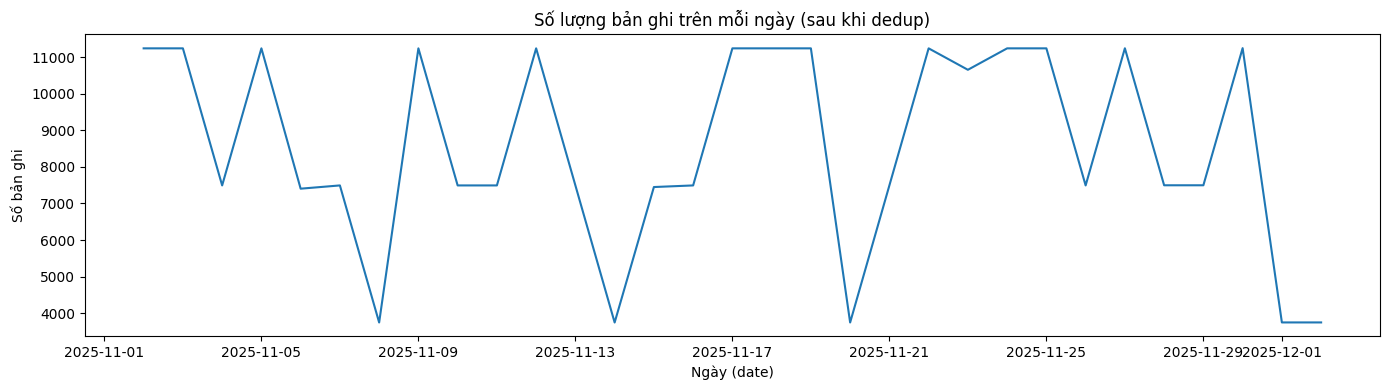

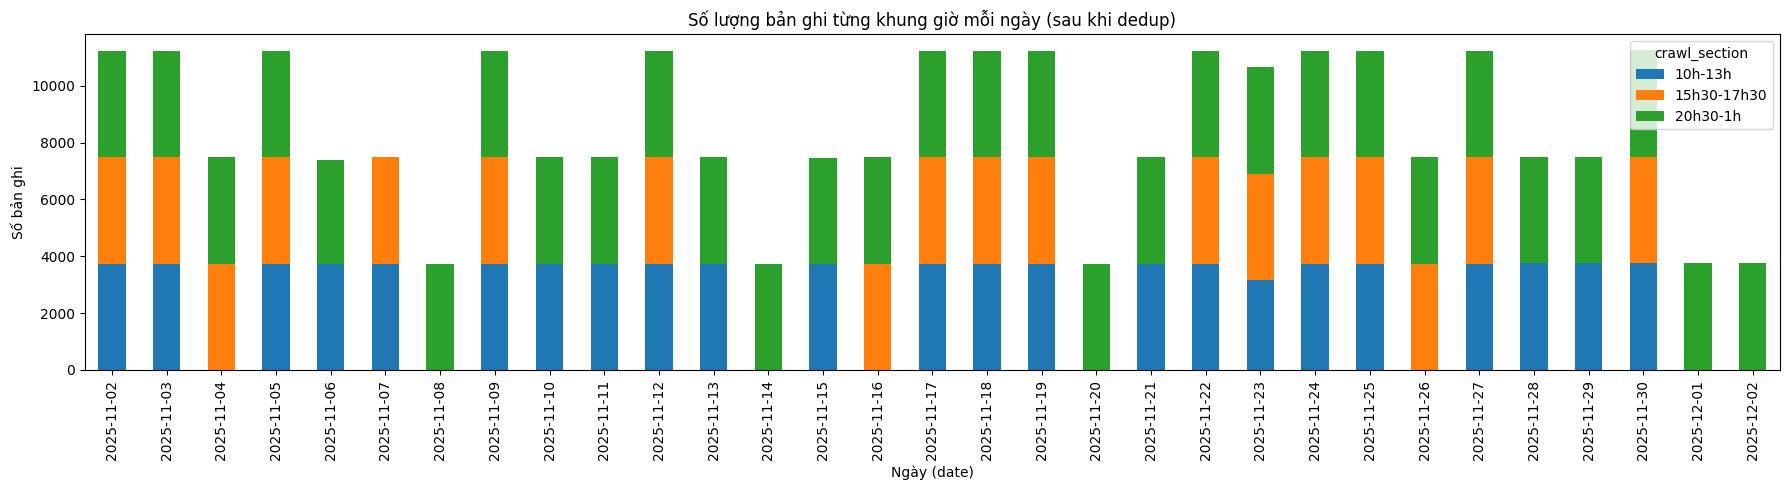

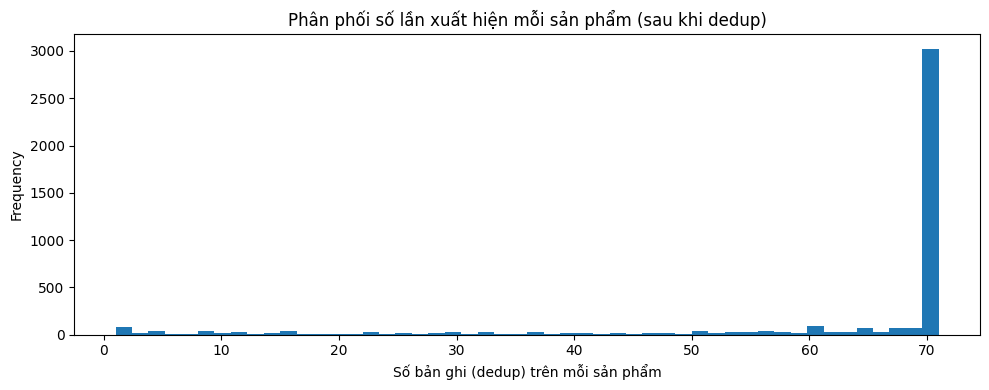

In [ ]:
import matplotlib.pyplot as plt

# Tổng quan: Số lượng bản ghi theo ngày (date)
plt.figure(figsize=(14,4))
price_history_cleaned_dedup['date'].value_counts().sort_index().plot()
plt.title("Số lượng bản ghi trên mỗi ngày (sau khi dedup)")
plt.xlabel("Ngày (date)")
plt.ylabel("Số bản ghi")
plt.tight_layout()
plt.show()

# Số lượng bản ghi theo từng khung giờ mỗi ngày
pivot = (
    price_history_cleaned_dedup
    .groupby(['date', 'crawl_section'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
pivot.plot(kind='bar', stacked=True, figsize=(18,5))
plt.title("Số lượng bản ghi từng khung giờ mỗi ngày (sau khi dedup)")
plt.xlabel("Ngày (date)")
plt.ylabel("Số bản ghi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Vậy là đã khớp với max số lượng bản ghi của 1 sản phẩm

In [82]:
price_history_cleaned = price_history_cleaned_dedup

In [84]:
count_stats = (
    price_history_cleaned
    .groupby('product_id')
    .size()
    .value_counts()
    .sort_index()
)

for times, n_products in count_stats.items():
    print(f"{times} lần xuất hiện: {n_products} sản phẩm")


1 lần xuất hiện: 41 sản phẩm
2 lần xuất hiện: 36 sản phẩm
3 lần xuất hiện: 14 sản phẩm
4 lần xuất hiện: 18 sản phẩm
5 lần xuất hiện: 20 sản phẩm
6 lần xuất hiện: 13 sản phẩm
7 lần xuất hiện: 12 sản phẩm
8 lần xuất hiện: 27 sản phẩm
9 lần xuất hiện: 17 sản phẩm
10 lần xuất hiện: 15 sản phẩm
11 lần xuất hiện: 17 sản phẩm
12 lần xuất hiện: 14 sản phẩm
13 lần xuất hiện: 10 sản phẩm
14 lần xuất hiện: 17 sản phẩm
15 lần xuất hiện: 38 sản phẩm
16 lần xuất hiện: 6 sản phẩm
17 lần xuất hiện: 7 sản phẩm
18 lần xuất hiện: 4 sản phẩm
19 lần xuất hiện: 7 sản phẩm
20 lần xuất hiện: 9 sản phẩm
21 lần xuất hiện: 7 sản phẩm
22 lần xuất hiện: 16 sản phẩm
23 lần xuất hiện: 13 sản phẩm
24 lần xuất hiện: 8 sản phẩm
25 lần xuất hiện: 10 sản phẩm
26 lần xuất hiện: 7 sản phẩm
27 lần xuất hiện: 9 sản phẩm
28 lần xuất hiện: 14 sản phẩm
29 lần xuất hiện: 17 sản phẩm
30 lần xuất hiện: 8 sản phẩm
31 lần xuất hiện: 11 sản phẩm
32 lần xuất hiện: 21 sản phẩm
33 lần xuất hiện: 10 sản phẩm
34 lần xuất hiện: 11 sản phẩm

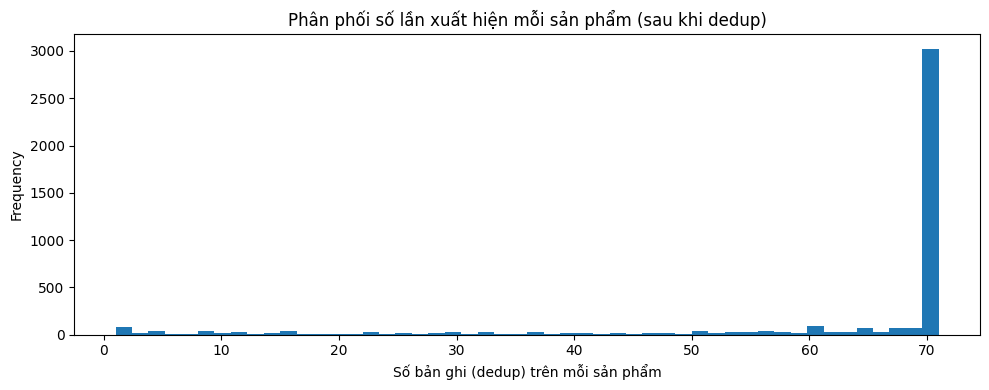

In [86]:
# Kiểm tra phân phối số lần xuất hiện mỗi sản phẩm
plt.figure(figsize=(10,4))
price_history_cleaned_dedup['product_id'].value_counts().plot.hist(bins=50)
plt.xlabel("Số bản ghi (dedup) trên mỗi sản phẩm")
plt.title("Phân phối số lần xuất hiện mỗi sản phẩm (sau khi dedup)")
plt.tight_layout()
plt.show()